# Assignment 06: Due 10/11

In this assignment we will look at some real data from the CMS experiment at the LHC. The LHC makes a lot of its data publically available here: http://opendata.cern.ch. The information about the data set we will be working with at can be found here: http://opendata.cern.ch/record/545

## Imports 

For this assignemnt you will need the following imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit #simpliest scipy fitting method
%matplotlib notebook

# Problem 1

Create a Pandas DataFrame object from the data file *Zee_Run2011A.csv*, located in the *data* dircetroy, and use the *info* function to list the information from the DataFrame.

In [2]:
df = pd.DataFrame(pd.read_csv('Zee_Run2011A.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18885 entries, 0 to 18884
Data columns (total 22 columns):
Run             18885 non-null int64
Event           18885 non-null int64
pt1             18885 non-null float64
eta1            18885 non-null float64
phi1            18885 non-null float64
Q1              18885 non-null int64
type1           18885 non-null object
sigmaEtaEta1    18885 non-null float64
HoverE1         18885 non-null float64
isoTrack1       18885 non-null float64
isoEcal1        18885 non-null float64
isoHcal1        18885 non-null float64
pt2             18885 non-null float64
eta2            18885 non-null float64
phi2            18885 non-null float64
Q2              18885 non-null int64
type2           18885 non-null object
sigmaEtaEta2    18885 non-null float64
HoverE2         18885 non-null float64
isoTrack2       18885 non-null float64
isoEcal2        18885 non-null float64
isoHcal2        18885 non-null float64
dtypes: float64(16), int64(4), object(2)
me

# Problem 2

Create a new DataFrame column, which lists the value of the reconstructed invariant mass, $m_{inv}$, from the $Z\rightarrow ee$ decay. The invariant mass is given by

$m_{inv} = \sqrt{2 p_{T1} p_{T2} \left(cosh\left(\eta_1 - \eta_2\right) - cos\left(\phi_1 -\phi_2\right) \right)}$

Make a histogram of the invariant mass.

,Run,Event,pt1,eta1,phi1,Q1,type1,sigmaEtaEta1,HoverE1,isoTrack1,...,eta2,phi2,Q2,type2,sigmaEtaEta2,HoverE2,isoTrack2,isoEcal2,isoHcal2,Invariant mass
0,163286,109060857,37.5667,2.289180,2.052600,-1,EE,0.025125,0.008973,0.00000,...,1.47064,-1.16305,1,EB,0.000753,0.000000,0.000000,1.019030,0.000000,89.589562
1,163286,109275715,36.2901,-0.837253,-1.585920,1,EB,0.007829,0.043751,0.00000,...,-0.48957,1.04960,-1,EB,0.011246,0.000000,0.718473,1.846060,0.000000,92.252290
2,163286,109075352,25.9705,-0.697420,1.635990,-1,EB,0.009715,0.040728,6.28701,...,-2.04009,3.11875,1,EE,0.025972,0.028008,15.217000,4.533720,3.836990,67.859158
3,163286,109169766,41.0075,1.461920,-0.532464,1,EB,0.008753,0.000000,0.00000,...,1.15606,2.47858,-1,EB,0.008590,0.000000,0.000000,2.438830,0.567555,87.604923
4,163286,108947653,39.8985,-0.592666,-2.394720,1,EB,0.015261,0.000000,2.54347,...,-2.24444,0.61061,-1,EE,0.029025,0.000000,12.422900,0.453359,0.909608,101.426755


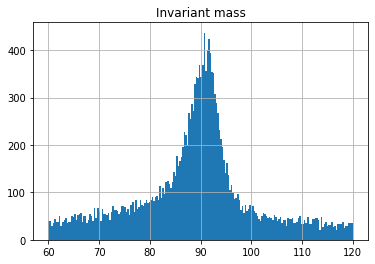

In [3]:
massinv = np.sqrt(2*df['pt1']*df['pt2']*(np.cosh(df['eta1']-df['eta2'])-np.cos(df['phi1']-df['phi2'])))
df['Invariant mass'] =massinv
df.hist('Invariant mass', bins =200);
df.head()
#invarient mass is the last column

# Problem 3

The Relativistic Breit-Wigner distribution is expected to describe the , which is given as

Wikepedia: https://en.wikipedia.org/wiki/Relativistic_Breit%E2%80%93Wigner_distribution

$f(E) = \frac{k}{(E^2 -M^2)^2 + M^2\Gamma^2}$, where

 * $\gamma$ = $\sqrt{M^2(M^2+\Gamma^2)}$
 * $k = \frac{2\sqrt{2}M\Gamma\gamma}{\pi\sqrt{M^2+\gamma}}$
 
 Where $E$ is the energy, $M$ is the mass value where the function will peak. 
 Fit the invariant mass distribution with the function:
 
 $aE + b + cf(E)$,
 
 where $a, b, $ and $c$ are fit parameters to be deterimined by your fit that describe a linear background, and $f(E)$ is the Relativistic Breit-Wigner function described above. To do this you should make a function that takes as agruments: $\Gamma, M, a, b, c$. Where $\Gamma$ and $M$ are contained in the Breit-Wigner function ($f(E)$). Our fit will determine the values $\Gamma, M, a, b, c$. The value of $M = m_{inv}$ and should be near where the distribution peaks.   
 
 Fit the distribution and calculate the reduced $\chi^2$. You can use either the *curve_fit* function form Scipy or the MC fitting approach.
 
 What is your best invariant mass value according to your fit? How does this compare to the accepted value of the $Z$ boson mass (you can look it up on Wikipedia)?

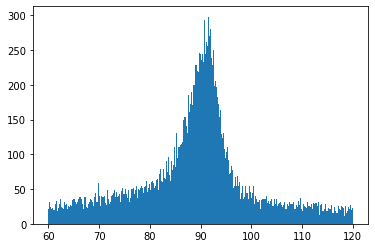

In [9]:
lowbound= 60
highbound= 120
bins=100
initialconditions = [2.5, 91, -2, 200, 13000]
#distribution is defined in next cell
distribution= plt.hist(massinv, bins= 300, range=(lowbound, highbound));
y= distribution[0]#event count
x= 0.5*(distribution[1][0:-1] + distribution[1][1:])
yerr= np.sqrt(y)

def bwdistribution(energy, gamma, m, a, b, c):
    lcgamma= np.sqrt(m**2*(m**2 + gamma**2))
    k= 2*np.sqrt(2)*m*gamma*lcgamma/(np.pi*np.sqrt(m**2+ lcgamma))
    d=(energy**2 - m**2)**2+(m**2)*(gamma**2)
    return a*energy + b + c*(k/d)

for i in range(len(y)):
    if yerr[i]==0:
        yerr[i]= 1.0
    else:
        yerr[i]= y[i]
params, variance, = curve_fit(bwdistribution, x, y, p0=initialconditions, sigma= yerr)
error= np.sqrt(np.diag(variance))

Best gamma Value 6.893498676241105
Best value for invarient mass 90.22235026050434


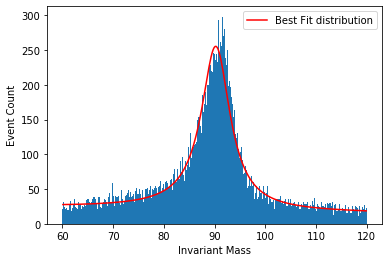

In [10]:
fig=plt.figure()
distribution= plt.hist(massinv, bins= 300, range=(lowbound, highbound))
plt.plot(x, bwdistribution(x, *params), 'r-', label = 'Best Fit distribution')
plt.xlabel("Invariant Mass")
plt.ylabel("Event Count")
plt.legend();

print("Best gamma Value",params[0])
print("Best value for invarient mass",params[1])

In [11]:
#for reduced chi squared
rchisq=sum(((distribution[0]-bwdistribution(x,params[0],params[1],params[2],params[3],params[4]))**2)/(yerr**2))
print("reduced chi squared",rchisq)

reduced chi squared 11.318371212171177


# Problem 4

On the same graph, make histograms of the $\eta_1$ and $\eta_2$ distributions. Be sure to include a legend so the two distributions can be distinquised.

Text(0.5, 1.0, 'Distributions of $\\eta_1$ and $\\eta_2$')

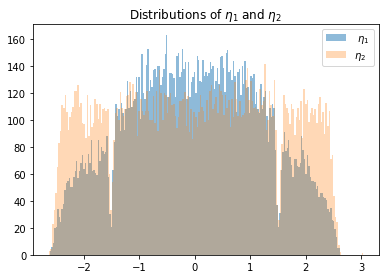

In [12]:
fig2= plt.figure()
axers= fig2.add_axes([0.8, 0.8, 0.8, 0.8])
axers.hist(df.eta1, alpha= 0.5, bins= 200, label =" $\eta_1$")
axers.hist(df.eta2, alpha= 0.3,  bins= 200, label = "$\eta_2$")
axers.legend()
axers.set_title("Distributions of $\eta_1$ and $\eta_2$")

# Problem 5

From the distribution above, we clearly see two distinct distributions in the histogram. We can explain this due to the decay particles being detected in two different detectors, the electromagnetic barrel calorimeter (EB) and the endcap electromagnetic calorimeter (EE). This distinction is made in the column labeled *type1* and *type2*, which tells us which detector particle 1 and particle 2 are detected in. 

Create two DataFrames *barrel* and *endcap*, where *barrel* keeps all of the information in the original DataFrame where both particles were detected in the EB, and *endcap* keeps all of the information in the original DataFrame where both particles were detected in the EE.

Make two sub plots where in sub plot one you histogram the $\eta1$ distribution for the particles in the EB and EE. Then in sub plot two histogram the $\eta2$ distribution for particles detected in the EE and EB. Be sure to include a legend that distiquishes EB from EE events. You should have something like that shown below:

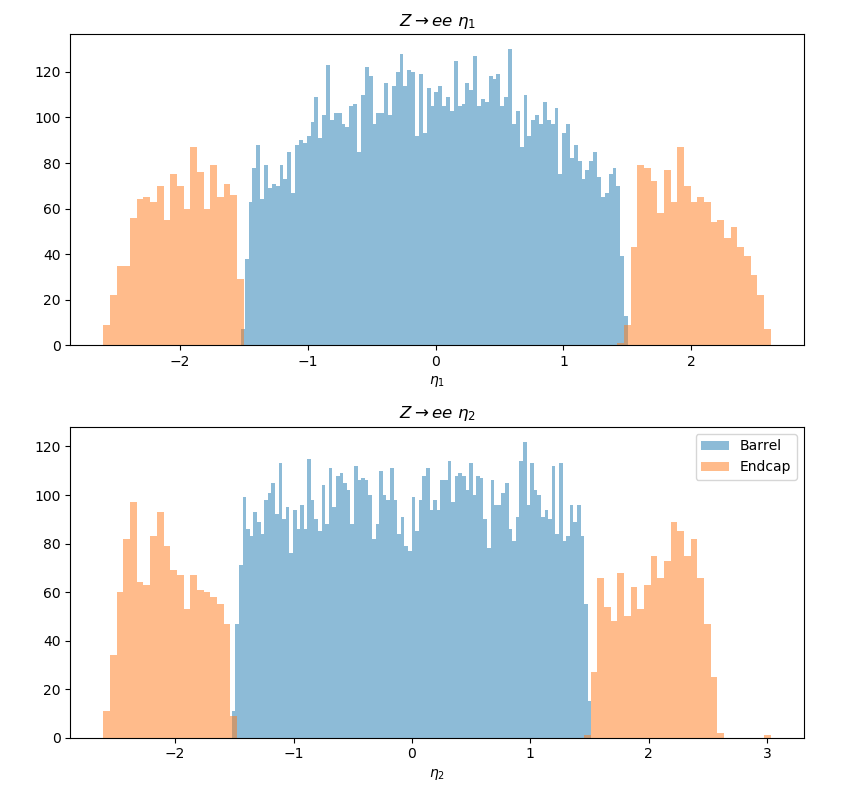

Based on the information above, does our assumption that the $\eta$ distribution looks the way it does is because of the two different detectors make sense? Based on your histograms, what is the rough $\eta$ ranges covered by the EB and EE detectors?

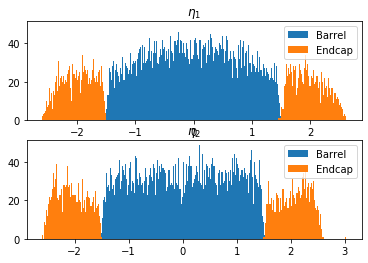

In [13]:
#create data frames for dectors
barrel = df[(df['type1']=='EB') & (df['type2']=='EB')]
endcap = df[(df['type1']=='EE') & (df['type2']=='EE')]

fig3, axus, = plt.subplots(2,1)
axus[0].hist(barrel.eta1, bins= 300, label= "Barrel")
axus[0].hist(endcap.eta1, bins= 300, label= "Endcap")
axus[0].set_title("$\eta_1$")
axus[0].legend()

axus[1].hist(barrel.eta2, bins= 300, label= "Barrel")
axus[1].hist(endcap.eta2, bins= 300, label= "Endcap")
axus[1].set_title("$\eta_2$")
axus[1].legend()

# Problem 6

With particles being detected in two different detectors, the resolution of the detectors could differ. This could reslt in measureing the boson mass better in one detector than the other.

Using your *barrel* and *endcap* DataFrames from above, on the same graph make a histogram of the invariant mass measured in the barrel and endcap detectors.  

Use the *std* function to get the standard deviation of the two invariant mass distributions. The standard deviation is reflective of how narrow our mass peak is. Which detector gives the better resolution and hence the narrower invariant mass distribution? Does your histogram support the same conclusion?

Barrel standard deviation: 11.489115344078318
Endcap standard deviation: 12.229202324653295


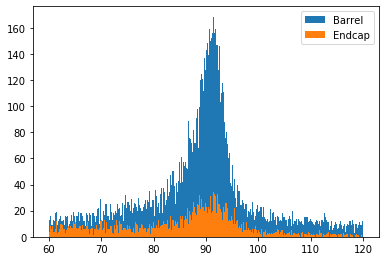

In [14]:
#need mass calculations for barrel and endcap
blue= (2*barrel.pt1*barrel.pt2)
green= np.cosh(barrel.eta1-barrel.eta2)
purple= np.cos(barrel.phi1-barrel.phi2)
barrelmass= np.sqrt(blue*(green-purple))

red= (2*endcap.pt1*endcap.pt2)
orange= np.cosh(endcap.eta1-endcap.eta2)
yellow= np.cos(endcap.phi1-endcap.phi2)
endcapmass= np.sqrt(red*(orange-yellow))

fig4= plt.figure()
axes4= fig4.add_axes([0.8,0.8,0.8,0.8])
axes4.hist(barrelmass, bins= 300, label= "Barrel")
axes4.hist(endcapmass, bins=300, label= 'Endcap')
axes4.legend();
print("Barrel standard deviation:", barrelmass.std())
print("Endcap standard deviation:", endcapmass.std())
#the barral standard dev > that of the end, imply thats the barrel is more accurate
#this can also be infered by looking at the histogram, the blue peak as it is much bigger
#however the standard deviation are relatively close to one another

# Problem 7
From your DataFrame (from Problem 2), drop all columns except for pt1, eta1, phi1, pt2, eta2, phi2, and M. 
Using this DataFrame, use the Pandas *corr* function to produce a correlataion table. What quantites have the strongest correlation (that is not 1)?

In [15]:
dfc=df.copy()
dfc= dfc[['pt1', 'eta1', 'phi1', 'pt2', 'eta2', 'phi2']]
dfc.head()

,pt1,eta1,phi1,pt2,eta2,phi2
0,37.5667,2.289180,2.052600,45.4315,1.47064,-1.16305
1,36.2901,-0.837253,-1.585920,60.5754,-0.48957,1.04960
2,25.9705,-0.697420,1.635990,45.2954,-2.04009,3.11875
3,41.0075,1.461920,-0.532464,45.9013,1.15606,2.47858
4,39.8985,-0.592666,-2.394720,34.8931,-2.24444,0.61061


In [16]:
dfc.corr()

,pt1,eta1,phi1,pt2,eta2,phi2
pt1,1.000000,-0.005495,-0.000376,-0.068503,-0.009661,-0.000184
eta1,-0.005495,1.000000,0.015935,0.009975,0.665429,-0.022004
phi1,-0.000376,0.015935,1.000000,0.000893,0.007323,-0.460515
pt2,-0.068503,0.009975,0.000893,1.000000,0.010027,-0.000399
eta2,-0.009661,0.665429,0.007323,0.010027,1.000000,-0.023955
phi2,-0.000184,-0.022004,-0.460515,-0.000399,-0.023955,1.000000


In [ ]:
#the relationship bewteen eta1 and eta 2 have the strongest correlation